In [1]:
import logging
import ast
from datasets import load_dataset
%load_ext autoreload
%autoreload 2
from chatsky_llm_autoconfig.settings import EnvSettings
from chatsky_llm_autoconfig.algorithms.three_stages_0 import ThreeStagesGraphGenerator
from chatsky_llm_autoconfig.dialogue import Dialogue
from chatsky_llm_autoconfig.graph import Graph
from chatsky_llm_autoconfig.algorithms.dialogue_generation import RecursiveDialogueSampler
from chatsky_llm_autoconfig.metrics.automatic_metrics import all_utterances_present

/home/peshkichev/miniconda3/envs/py11/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(


In [2]:
logging.getLogger("langchain_core.vectorstores.base").setLevel(logging.ERROR)
env_settings = EnvSettings()

In [3]:
graph_generator = ThreeStagesGraphGenerator()
dialogue_sampler = RecursiveDialogueSampler()

In [4]:
def add_dialogues(graph: Graph, dialogues: list[Dialogue]):
     if graph:
         sampled_dialogues = dialogue_sampler.invoke(graph, 15)
         data = (sampled_dialogues+dialogues).copy()
     else:
          data = dialogues
     return graph_generator.invoke(data)


## MULTIWOZ2_2

In [9]:
dataset = load_dataset('Salesforce/dialogstudio', 'MULTIWOZ2_2', token=env_settings.HUGGINGFACE_TOKEN, trust_remote_code=True)

Using the latest cached version of the module from /home/peshkichev/.cache/huggingface/modules/datasets_modules/datasets/Salesforce--dialogstudio/5778b28eb3729807803ab09b88c9f4dfcd41134879e168fdcccd16d3d5559da7 (last modified on Tue Feb 18 07:54:50 2025) since it couldn't be found locally at Salesforce/dialogstudio, or remotely on the Hugging Face Hub.


In [4]:
dataset['test'][0]

{'original dialog id': 'PMUL3520.json',
 'new dialog id': 'MULTIWOZ2_2--test--1',
 'dialog index': 1,
 'original dialog info': '{"services": ["restaurant", "train"]}',
 'log': [{'turn id': 1,
   'user utterance': 'I need a train going to Cambridge that will depart after 10:15 from broxbourne.',
   'system response': 'I have train TR5678 that would suit you.',
   'dialog history': '',
   'original user side information': '{"frames": [{"actions": [], "service": "train", "slots": [{"exclusive_end": 62, "slot": "train-leaveat", "start": 57, "value": "10:15"}], "state": {"active_intent": "find_train", "requested_slots": [], "slot_values": {"train-departure": ["broxbourne"], "train-destination": ["cambridge"], "train-leaveat": ["10:15"]}}}, {"actions": [], "service": "taxi", "slots": [], "state": {"active_intent": "NONE", "requested_slots": [], "slot_values": {}}}, {"actions": [], "service": "bus", "slots": [], "state": {"active_intent": "NONE", "requested_slots": [], "slot_values": {}}}, {"

### Restaurant dialogues

In [10]:
data = [d for d in dataset['test'] if ast.literal_eval(d['original dialog info'])["services"]==["restaurant"]]

In [77]:
data = [d for d in dataset['test'] if ast.literal_eval(d['original dialog info'])["services"]==["restaurant", "train"]]

In [6]:
data = [d for d in dataset['test'] if ast.literal_eval(d['original dialog info'])["services"]==["train"]]

In [29]:
data[0]

{'original dialog id': 'SNG0661.json',
 'new dialog id': 'MULTIWOZ2_2--test--6',
 'dialog index': 6,
 'original dialog info': '{"services": ["restaurant"]}',
 'log': [{'turn id': 1,
   'user utterance': "I'm looking for an Indian restaurant, preferably in the centre of town.",
   'system response': 'There are a number of options for Indian restaurants in the centre of town. What price range would you like?',
   'dialog history': '',
   'original user side information': '{"frames": [{"actions": [], "service": "restaurant", "slots": [{"exclusive_end": 25, "slot": "restaurant-food", "start": 19, "value": "Indian"}], "state": {"active_intent": "find_restaurant", "requested_slots": [], "slot_values": {"restaurant-area": ["centre"], "restaurant-food": ["indian"]}}}, {"actions": [], "service": "taxi", "slots": [], "state": {"active_intent": "NONE", "requested_slots": [], "slot_values": {}}}, {"actions": [], "service": "train", "slots": [], "state": {"active_intent": "NONE", "requested_slots":

In [30]:
len(data)

65

In [11]:
new_data=[]
for d in data:
    exist = [[{"text":u['user utterance'],"participant":"user"},{"text":u['system response'],"participant":"assistant"}] for u in d['log']]
    new_data.append([{"text":"Hello! How can I help you?","participant":"assistant"}] + [x for xs in exist for x in xs])

#### 1 dialogue

In [12]:
test_data = [Dialogue.from_list(c) for c in new_data[:1]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/algorithms/three_stages_0.py:76: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=env_settings.EMBEDDER_MODEL, model_kwargs={"device": env_settings.EMBEDDER_DEVICE})
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'greeting', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_price_range', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']}, {'id': 3, 'label': 'recommend_restaurant', 'is_start': False, 'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']}, {'id': 4, 'label': 'confirm_booking', 'is_start': False, 'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?']}, {'id': 5, 'label': 'farewell', 'is_start': False, 'utterances': ['Thank you for calling, enjoy!']}], 'reason': "No assistant's utterances had similar surrounding intents to be grouped."}


INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


RESULT:  {'edges': [{'source': 1, 'target': 2, 'utterances': ["I'm looking for an Indian restaurant, preferably in the centre of town."]}, {'source': 2, 'target': 3, 'utterances': ['I would prefer cheap restaurants.']}, {'source': 3, 'target': 4, 'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']}, {'source': 4, 'target': 5, 'utterances': ["No that's all I needed. Thank you!"]}], 'nodes': [{'id': 1, 'label': 'greeting', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_price_range', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']}, {'id': 3, 'label': 'recommend_restaurant', 'is_start': False, 'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']}, {'id': 4, 'label': 'confirm_booking', 'is_start': False, 'utterances': ['I was able to book that for you. They will be reserve y

True

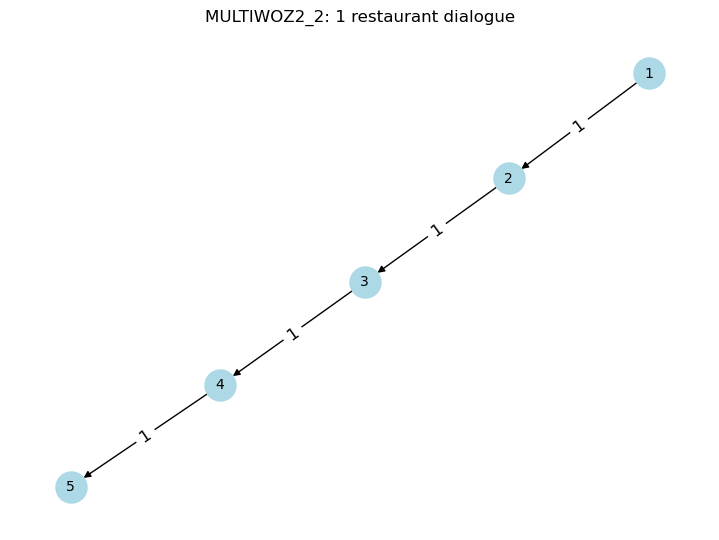

In [13]:
graph.visualise_short("MULTIWOZ2_2: 1 restaurant dialogue")

In [14]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'greeting',
  'is_start': True,
  'utterances': ['Hello! How can I help you?']},
 {'id': 2,
  'label': 'ask_price_range',
  'is_start': False,
  'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']},
 {'id': 3,
  'label': 'recommend_restaurant',
  'is_start': False,
  'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']},
 {'id': 4,
  'label': 'confirm_booking',
  'is_start': False,
  'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?']},
 {'id': 5,
  'label': 'farewell',
  'is_start': False,
  'utterances': ['Thank you for calling, enjoy!']}]

In [15]:
graph.graph_dict['edges']

[{'source': 1,
  'target': 2,
  'utterances': ["I'm looking for an Indian restaurant, preferably in the centre of town."]},
 {'source': 2,
  'target': 3,
  'utterances': ['I would prefer cheap restaurants.']},
 {'source': 3,
  'target': 4,
  'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']},
 {'source': 4,
  'target': 5,
  'utterances': ["No that's all I needed. Thank you!"]}]

#### 2 dialogues

In [16]:
test_data = [Dialogue.from_list(c) for c in new_data[:2]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_price_range', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']}, {'id': 3, 'label': 'recommend_restaurant', 'is_start': False, 'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']}, {'id': 4, 'label': 'confirm_booking', 'is_start': False, 'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?', 'You are booked, the reference number is AF2GJ7G6, may I assist with anything else?']}, {'id': 5, 'label': 'end', 'is_start': False, 'utterances': ['Thank you for calling, enjoy!', "You're welcome. Thank you for contacting Cambridge TownInfo centre, and have a great day."]}, {'id': 6, 'label': 'offer_rest

False

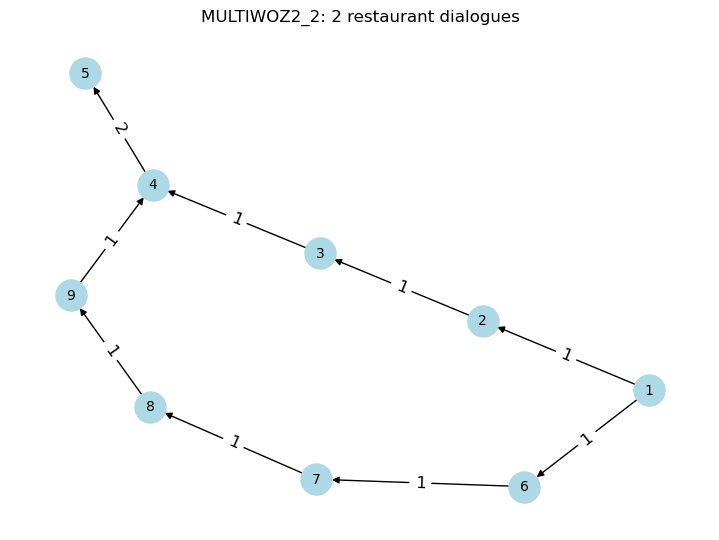

In [17]:
graph.visualise_short("MULTIWOZ2_2: 2 restaurant dialogues")

In [18]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello! How can I help you?']},
 {'id': 2,
  'label': 'ask_price_range',
  'is_start': False,
  'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']},
 {'id': 3,
  'label': 'recommend_restaurant',
  'is_start': False,
  'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']},
 {'id': 4,
  'label': 'confirm_booking',
  'is_start': False,
  'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?',
   'You are booked, the reference number is AF2GJ7G6, may I assist with anything else?']},
 {'id': 5,
  'label': 'end',
  'is_start': False,
  'utterances': ['Thank you for calling, enjoy!',
   "You're welcome. Thank you for contacting Cambridge TownInfo centre, and have a great day."]},
 {'id': 

In [19]:
graph.graph_dict['edges']

[{'source': 1,
  'target': 2,
  'utterances': ["I'm looking for an Indian restaurant, preferably in the centre of town."]},
 {'source': 2,
  'target': 3,
  'utterances': ['I would prefer cheap restaurants.']},
 {'source': 3,
  'target': 4,
  'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']},
 {'source': 1,
  'target': 6,
  'utterances': ['I am looking for a restaurant. The restaurant should be in the moderate price range and should be in the east']},
 {'source': 4,
  'target': 5,
  'utterances': ["No that's all I needed. Thank you!",
   'Thanks for you help. I only need the restaurant reservation. Goodbye.']},
 {'source': 6,
  'target': 7,
  'utterances': ['The restaurant should serve italian food.']},
 {'source': 7,
  'target': 8,
  'utterances': ['What other restaurants in that area serve Italian food?']},
 {'source': 8,
  'target': 9,
  'utterances': ['No, that will do. Can I book a table for monday?']},
 {'source': 9,
  'target': 4,
  'utterances'

#### 3 dialogues

In [20]:
test_data = [Dialogue.from_list(c) for c in new_data[:3]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'node_2', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']}, {'id': 3, 'label': 'node_3', 'is_start': False, 'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']}, {'id': 4, 'label': 'node_4', 'is_start': False, 'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?']}, {'id': 5, 'label': 'node_5', 'is_start': False, 'utterances': ['Thank you for calling, enjoy!']}, {'id': 6, 'label': 'node_6', 'is_start': False, 'utterances': ['Try curry prince or pizza hut fen ditton']}, {'id': 7, 'label': 'node_7', 'is_start': False, 'utterances': ['Pizza hut fen ditton serves italian food in the east, would you l

True

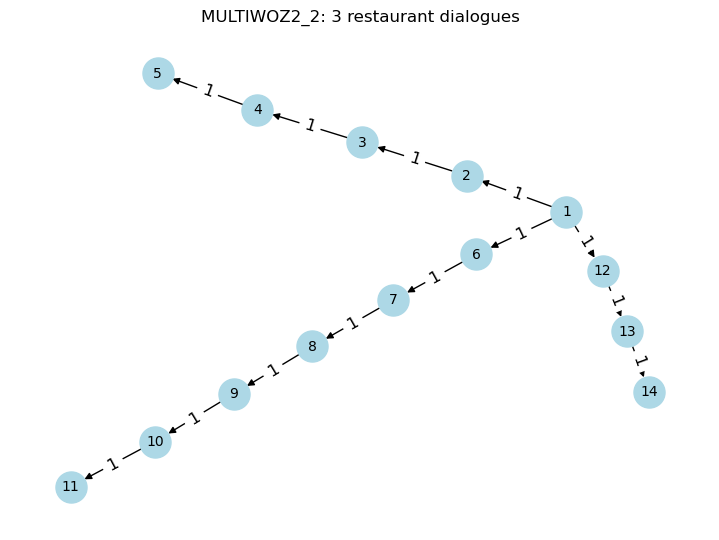

In [21]:
graph.visualise_short("MULTIWOZ2_2: 3 restaurant dialogues")

In [22]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello! How can I help you?']},
 {'id': 2,
  'label': 'node_2',
  'is_start': False,
  'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']},
 {'id': 3,
  'label': 'node_3',
  'is_start': False,
  'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']},
 {'id': 4,
  'label': 'node_4',
  'is_start': False,
  'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?']},
 {'id': 5,
  'label': 'node_5',
  'is_start': False,
  'utterances': ['Thank you for calling, enjoy!']},
 {'id': 6,
  'label': 'node_6',
  'is_start': False,
  'utterances': ['Try curry prince or pizza hut fen ditton']},
 {'id': 7,
  'label': 'node_7',
  'is_start': False,
  'utterances': ['Pizza hut fen ditton serves italian

In [23]:
graph.graph_dict['edges']

[{'source': 1,
  'target': 2,
  'utterances': ["I'm looking for an Indian restaurant, preferably in the centre of town."]},
 {'source': 2,
  'target': 3,
  'utterances': ['I would prefer cheap restaurants.']},
 {'source': 3,
  'target': 4,
  'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']},
 {'source': 4,
  'target': 5,
  'utterances': ["No that's all I needed. Thank you!"]},
 {'source': 1,
  'target': 6,
  'utterances': ['I am looking for a restaurant. The restaurant should be in the moderate price range and should be in the east']},
 {'source': 6,
  'target': 7,
  'utterances': ['The restaurant should serve italian food.']},
 {'source': 7,
  'target': 8,
  'utterances': ['What other restaurants in that area serve Italian food?']},
 {'source': 8,
  'target': 9,
  'utterances': ['No, that will do. Can I book a table for monday?']},
 {'source': 9,
  'target': 10,
  'utterances': ['I will have 5 people and we would like 12:15 if possible. Thanks.']},
 

### 4 dialogues

In [24]:
test_data = [Dialogue.from_list(c) for c in new_data[:4]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_price_range', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']}, {'id': 3, 'label': 'recommend_restaurant', 'is_start': False, 'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']}, {'id': 4, 'label': 'confirm_booking', 'is_start': False, 'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?']}, {'id': 5, 'label': 'end_call', 'is_start': False, 'utterances': ['Thank you for calling, enjoy!']}, {'id': 6, 'label': 'suggest_restaurants', 'is_start': False, 'utterances': ['Try curry prince or pizza hut fen ditton']}, {'id': 7, 'label': 'offer_reservation', 'is_start': False, 'utterances': ['Pizza h

True

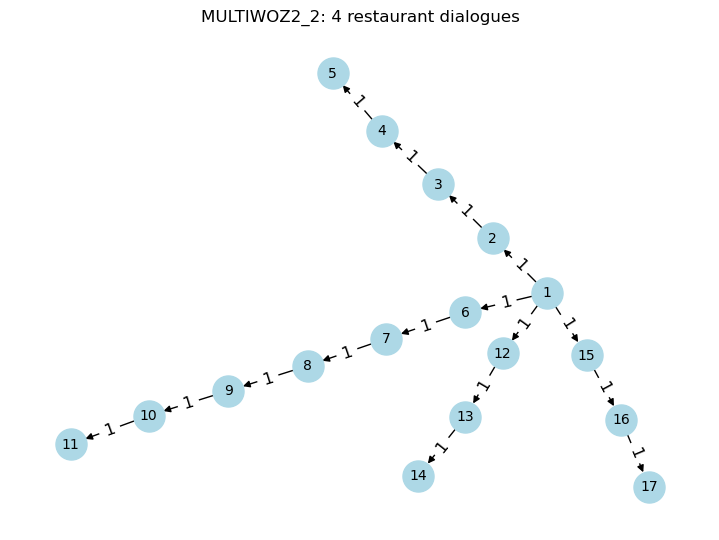

In [25]:
graph.visualise_short("MULTIWOZ2_2: 4 restaurant dialogues")

In [26]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello! How can I help you?']},
 {'id': 2,
  'label': 'ask_price_range',
  'is_start': False,
  'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']},
 {'id': 3,
  'label': 'recommend_restaurant',
  'is_start': False,
  'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']},
 {'id': 4,
  'label': 'confirm_booking',
  'is_start': False,
  'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?']},
 {'id': 5,
  'label': 'end_call',
  'is_start': False,
  'utterances': ['Thank you for calling, enjoy!']},
 {'id': 6,
  'label': 'suggest_restaurants',
  'is_start': False,
  'utterances': ['Try curry prince or pizza hut fen ditton']},
 {'id': 7,
  'label': 'offer_reservation',
  'is_start': Fa

In [27]:
graph.graph_dict['edges']

[{'source': 1,
  'target': 2,
  'utterances': ["I'm looking for an Indian restaurant, preferably in the centre of town."]},
 {'source': 2,
  'target': 3,
  'utterances': ['I would prefer cheap restaurants.']},
 {'source': 3,
  'target': 4,
  'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']},
 {'source': 4,
  'target': 5,
  'utterances': ["No that's all I needed. Thank you!"]},
 {'source': 1,
  'target': 6,
  'utterances': ['I am looking for a restaurant. The restaurant should be in the moderate price range and should be in the east']},
 {'source': 6,
  'target': 7,
  'utterances': ['The restaurant should serve italian food.']},
 {'source': 7,
  'target': 8,
  'utterances': ['What other restaurants in that area serve Italian food?']},
 {'source': 8,
  'target': 9,
  'utterances': ['No, that will do. Can I book a table for monday?']},
 {'source': 9,
  'target': 10,
  'utterances': ['I will have 5 people and we would like 12:15 if possible. Thanks.']},
 

#### 5 dialogues

## META_WOZ

In [5]:
dataset = load_dataset('microsoft/meta_woz', trust_remote_code=True)

### BOOKING_FLIGHT

In [6]:
new_data=[]
for d in [el['turns'] for el in dataset['test'] if el['domain'] == 'BOOKING_FLIGHT']:
    exist = [[{"text":a,"participant":"assistant"},{"text":u,"participant":"user"}] for a,u in zip(d[0:-1:2],d[1::2])]+[[{"text":d[-1],"participant":"assistant"}]]
    new_data.append([x for xs in exist for x in xs])

In [37]:
len(new_data)

554

#### 2 dialogues

In [10]:
new_data[:2]

[[{'text': 'Hello how may I help you?', 'participant': 'assistant'},
  {'text': 'Hello, I want to book a flight.', 'participant': 'user'},
  {'text': 'Can I help you book a flight to greece?',
   'participant': 'assistant'},
  {'text': "Yes that's where I want to go.", 'participant': 'user'},
  {'text': 'Perfect, and when would you like to leave?',
   'participant': 'assistant'},
  {'text': 'I want to leave from Dallas.', 'participant': 'user'},
  {'text': 'Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?',
   'participant': 'assistant'},
  {'text': 'I want to leave by next Friday.', 'participant': 'user'},
  {'text': 'Alright booking your flight between now and next friday. You will be alerted when your flight is book and vased on the lowest available price.',
   'participant': 'assistant'},
  {'text': "Wait please don't do that, I was only curious. I don't actually want to book a flight",
   'participant': 'user'},
  {'text': 'F

In [7]:
test_data = [Dialogue.from_list(c) for c in new_data[:2]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/algorithms/three_stages_0.py:76: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=env_settings.EMBEDDER_MODEL, model_kwargs={"device": env_settings.EMBEDDER_DEVICE})
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello how may I help you?']}, {'id': 2, 'label': 'can_help_book_flight_to_greece', 'is_start': False, 'utterances': ['Can I help you book a flight to greece?']}, {'id': 3, 'label': 'perfect_when_leave', 'is_start': False, 'utterances': ['Perfect, and when would you like to leave?']}, {'id': 4, 'label': 'flight_details_leave_when', 'is_start': False, 'utterances': ['Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?']}, {'id': 5, 'label': 'booking_flight_alert_price', 'is_start': False, 'utterances': ['Alright booking your flight between now and next friday. You will be alerted when your flight is book and vased on the lowest available price.']}, {'id': 6, 'label': 'flight_booking_cancelled', 'is_start': False, 'utterances': ['Flight booking has been cancelled. We hope to see you again soon.']}, {'id': 7, 'label': 'sure', 'is_start': False, 'utterances':

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='2', metadata={'id': 2}, page_content='Perfect, and when would you like to leave?'), 0.15744547028550726), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096082630853235), (Document(id='1', metadata={'id': 1}, page_content='Can I help you book a flight to greece?'), 0.08380725521054644), (Document(id='5', metadata={'id': 5}, page_content='Flight booking has been cancelled. We hope to see you again soon.'), 0.06941022893401316), (Document(id='3', metadata={'id': 3}, page_content='Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?'), 0.02203430522206

RESULT:  {'edges': [{'source': 1, 'target': 2, 'utterances': ['Hello, I want to book a flight.']}, {'source': 2, 'target': 3, 'utterances': ["Yes that's where I want to go."]}, {'source': 3, 'target': 4, 'utterances': ['I want to leave from Dallas.']}, {'source': 4, 'target': 5, 'utterances': ['I want to leave by next Friday.']}, {'source': 5, 'target': 6, 'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]}, {'source': 1, 'target': 7, 'utterances': ['I need some help with some information please']}, {'source': 7, 'target': 8, 'utterances': ['how do I get a flight to Greece?']}, {'source': 8, 'target': 9, 'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]}, {'source': 9, 'target': 10, 'utterances': ['Okay, that seems pretty easy']}, {'source': 10, 'target': 11, 'utterances': ['Nope, thanks for your help!']}], 'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello ho

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='5', metadata={'id': 5}, page_content='Great'), 0.9999999999990536), (Document(id='1', metadata={'id': 1}, page_content='Sure'), 0.3456119720705767), (Document(id='4', metadata={'id': 4}, page_content='Anything else?'), 0.21399920743548617), (Document(id='2', metadata={'id': 2}, page_content='I can book a flight for you'), 0.15012144383237513), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096091060222937), (Document(id='3', metadata={'id': 3}, page_content='You can check airports has a schedule flight to Greece and there you can book a flight if you want to'), -0.0019150513883670062)]
  docs = self.assistant_store.similarity_search_with_relevance_scores(utterance, k=self.assistant_size, score_threshold=env_settings.EMBEDDER_TYPO)


True

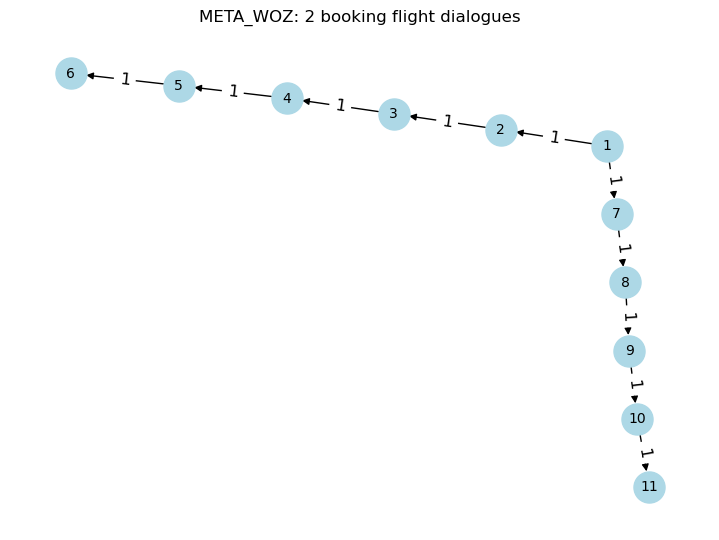

In [8]:
graph.visualise_short("META_WOZ: 2 booking flight dialogues")

In [11]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello how may I help you?']},
 {'id': 2,
  'label': 'can_help_book_flight_to_greece',
  'is_start': False,
  'utterances': ['Can I help you book a flight to greece?']},
 {'id': 3,
  'label': 'perfect_when_leave',
  'is_start': False,
  'utterances': ['Perfect, and when would you like to leave?']},
 {'id': 4,
  'label': 'flight_details_leave_when',
  'is_start': False,
  'utterances': ['Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?']},
 {'id': 5,
  'label': 'booking_flight_alert_price',
  'is_start': False,
  'utterances': ['Alright booking your flight between now and next friday. You will be alerted when your flight is book and vased on the lowest available price.']},
 {'id': 6,
  'label': 'flight_booking_cancelled',
  'is_start': False,
  'utterances': ['Flight booking has been cancelled. We hope to see you again soon.']},
 {'id': 7, 'label': 'sure', 'is_star

In [12]:
graph.graph_dict['edges']

[{'source': 1, 'target': 2, 'utterances': ['Hello, I want to book a flight.']},
 {'source': 2, 'target': 3, 'utterances': ["Yes that's where I want to go."]},
 {'source': 3, 'target': 4, 'utterances': ['I want to leave from Dallas.']},
 {'source': 4, 'target': 5, 'utterances': ['I want to leave by next Friday.']},
 {'source': 5,
  'target': 6,
  'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]},
 {'source': 1,
  'target': 7,
  'utterances': ['I need some help with some information please']},
 {'source': 7,
  'target': 8,
  'utterances': ['how do I get a flight to Greece?']},
 {'source': 8,
  'target': 9,
  'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]},
 {'source': 9, 'target': 10, 'utterances': ['Okay, that seems pretty easy']},
 {'source': 10, 'target': 11, 'utterances': ['Nope, thanks for your help!']}]

#### <span style="color:green">2 dialogues graph is correct</span>

#### 3 dialogues

In [18]:
new_data[:3]

[[{'text': 'Hello how may I help you?', 'participant': 'assistant'},
  {'text': 'Hello, I want to book a flight.', 'participant': 'user'},
  {'text': 'Can I help you book a flight to greece?',
   'participant': 'assistant'},
  {'text': "Yes that's where I want to go.", 'participant': 'user'},
  {'text': 'Perfect, and when would you like to leave?',
   'participant': 'assistant'},
  {'text': 'I want to leave from Dallas.', 'participant': 'user'},
  {'text': 'Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?',
   'participant': 'assistant'},
  {'text': 'I want to leave by next Friday.', 'participant': 'user'},
  {'text': 'Alright booking your flight between now and next friday. You will be alerted when your flight is book and vased on the lowest available price.',
   'participant': 'assistant'},
  {'text': "Wait please don't do that, I was only curious. I don't actually want to book a flight",
   'participant': 'user'},
  {'text': 'F

In [93]:
test_data = [Dialogue.from_list(c) for c in new_data[:3]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello how may I help you?']}, {'id': 2, 'label': 'provide_confirmation', 'is_start': False, 'utterances': ['Sure', 'sure what do you wanna know?']}, {'id': 3, 'label': 'anything_else', 'is_start': False, 'utterances': ['Anything else?', 'ohh okay anything else you need to know?']}, {'id': 4, 'label': 'confirm_booking', 'is_start': False, 'utterances': ['Can I help you book a flight to greece?']}, {'id': 5, 'label': 'ask_departure', 'is_start': False, 'utterances': ['Perfect, and when would you like to leave?']}, {'id': 6, 'label': 'confirm_flight_details', 'is_start': False, 'utterances': ['Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?']}, {'id': 7, 'label': 'book_flight', 'is_start': False, 'utterances': ['Alright booking your flight between now and next friday. You will be alerted when your flight is book and vased on the lowest available price.'

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='2', metadata={'id': 2}, page_content='Perfect, and when would you like to leave?'), 0.15744547028550726), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096082630853235), (Document(id='1', metadata={'id': 1}, page_content='Can I help you book a flight to greece?'), 0.08380725521054644), (Document(id='5', metadata={'id': 5}, page_content='Flight booking has been cancelled. We hope to see you again soon.'), 0.06941022893401316), (Document(id='3', metadata={'id': 3}, page_content='Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?'), 0.022034305222069506), (Document(id='4', metadata={'id': 4}, page_content='Alright booking your flight between now and next friday. You will be alerted when your flight 

RESULT:  {'edges': [{'source': 1, 'target': 4, 'utterances': ['Hello, I want to book a flight.']}, {'source': 4, 'target': 5, 'utterances': ["Yes that's where I want to go."]}, {'source': 5, 'target': 6, 'utterances': ['I want to leave from Dallas.']}, {'source': 6, 'target': 7, 'utterances': ['I want to leave by next Friday.']}, {'source': 7, 'target': 8, 'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]}, {'source': 2, 'target': 9, 'utterances': ['how do I get a flight to Greece?']}, {'source': 3, 'target': 11, 'utterances': ['Nope, thanks for your help!']}, {'source': 9, 'target': 10, 'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]}, {'source': 10, 'target': 3, 'utterances': ['Okay, that seems pretty easy']}, {'source': 1, 'target': 2, 'utterances': ['I need some help with some information please', 'I need some travel information please.']}, {'source': 2, 'target': 12, 'utterances

False

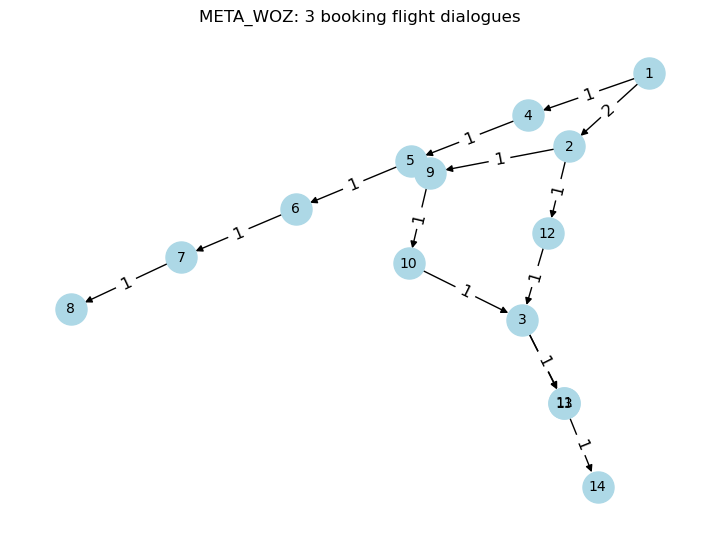

In [94]:
graph.visualise_short("META_WOZ: 3 booking flight dialogues")

In [95]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello how may I help you?']},
 {'id': 2,
  'label': 'provide_confirmation',
  'is_start': False,
  'utterances': ['Sure', 'sure what do you wanna know?']},
 {'id': 3,
  'label': 'anything_else',
  'is_start': False,
  'utterances': ['Anything else?',
   'ohh okay anything else you need to know?']},
 {'id': 4,
  'label': 'confirm_booking',
  'is_start': False,
  'utterances': ['Can I help you book a flight to greece?']},
 {'id': 5,
  'label': 'ask_departure',
  'is_start': False,
  'utterances': ['Perfect, and when would you like to leave?']},
 {'id': 6,
  'label': 'confirm_flight_details',
  'is_start': False,
  'utterances': ['Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?']},
 {'id': 7,
  'label': 'book_flight',
  'is_start': False,
  'utterances': ['Alright booking your flight between now and next friday. You will be alerted when your flight is book and vase

In [96]:
graph.graph_dict['edges']

[{'source': 1, 'target': 4, 'utterances': ['Hello, I want to book a flight.']},
 {'source': 4, 'target': 5, 'utterances': ["Yes that's where I want to go."]},
 {'source': 5, 'target': 6, 'utterances': ['I want to leave from Dallas.']},
 {'source': 6, 'target': 7, 'utterances': ['I want to leave by next Friday.']},
 {'source': 7,
  'target': 8,
  'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]},
 {'source': 2,
  'target': 9,
  'utterances': ['how do I get a flight to Greece?']},
 {'source': 3, 'target': 11, 'utterances': ['Nope, thanks for your help!']},
 {'source': 9,
  'target': 10,
  'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]},
 {'source': 10, 'target': 3, 'utterances': ['Okay, that seems pretty easy']},
 {'source': 1,
  'target': 2,
  'utterances': ['I need some help with some information please',
   'I need some travel information please.']},
 {'source': 2,
  'target': 12,

#### <span style="color:green">3 dialogues graph is correct</span>

#### 4 dialogues

In [36]:
new_data[:4]

[[{'text': 'Hello how may I help you?', 'participant': 'assistant'},
  {'text': 'Hello, I want to book a flight.', 'participant': 'user'},
  {'text': 'Can I help you book a flight to greece?',
   'participant': 'assistant'},
  {'text': "Yes that's where I want to go.", 'participant': 'user'},
  {'text': 'Perfect, and when would you like to leave?',
   'participant': 'assistant'},
  {'text': 'I want to leave from Dallas.', 'participant': 'user'},
  {'text': 'Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?',
   'participant': 'assistant'},
  {'text': 'I want to leave by next Friday.', 'participant': 'user'},
  {'text': 'Alright booking your flight between now and next friday. You will be alerted when your flight is book and vased on the lowest available price.',
   'participant': 'assistant'},
  {'text': "Wait please don't do that, I was only curious. I don't actually want to book a flight",
   'participant': 'user'},
  {'text': 'F

In [97]:
test_data = [Dialogue.from_list(c) for c in new_data[:4]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello how may I help you?']}, {'id': 2, 'label': 'provide_confirmation', 'is_start': False, 'utterances': ['Sure', 'sure what do you wanna know?']}, {'id': 3, 'label': 'offer_flight_booking', 'is_start': False, 'utterances': ['I can book a flight for you', 'i can book you a flight there to save you some time']}, {'id': 4, 'label': 'ask_anything_else', 'is_start': False, 'utterances': ['Anything else?', 'ohh okay anything else you need to know?', 'I have booked that airline for you, anything else/']}, {'id': 5, 'label': 'ask_book_flight_to_greece', 'is_start': False, 'utterances': ['Can I help you book a flight to greece?']}, {'id': 6, 'label': 'ask_departure_time', 'is_start': False, 'utterances': ['Perfect, and when would you like to leave?']}, {'id': 7, 'label': 'confirm_departure', 'is_start': False, 'utterances': ['Alright, i have your flight leaving from dallas and landing in athens. When would you li

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='2', metadata={'id': 2}, page_content='Perfect, and when would you like to leave?'), 0.15744547028550726), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096082630853235), (Document(id='1', metadata={'id': 1}, page_content='Can I help you book a flight to greece?'), 0.08380725521054644), (Document(id='5', metadata={'id': 5}, page_content='Flight booking has been cancelled. We hope to see you again soon.'), 0.06941022893401316), (Document(id='3', metadata={'id': 3}, page_content='Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?'), 0.022034305222069506), (Document(id='4', metadata={'id': 4}, page_content='Alright booking your flight between now and next friday. You will be alerted when your flight 

RESULT:  {'edges': [{'source': 1, 'target': 5, 'utterances': ['Hello, I want to book a flight.']}, {'source': 5, 'target': 6, 'utterances': ["Yes that's where I want to go."]}, {'source': 6, 'target': 7, 'utterances': ['I want to leave from Dallas.']}, {'source': 7, 'target': 8, 'utterances': ['I want to leave by next Friday.']}, {'source': 8, 'target': 9, 'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]}, {'source': 3, 'target': 10, 'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]}, {'source': 4, 'target': 11, 'utterances': ['Nope, thanks for your help!']}, {'source': 10, 'target': 4, 'utterances': ['Okay, that seems pretty easy']}, {'source': 1, 'target': 2, 'utterances': ['I need some help with some information please', 'I need some travel information please.']}, {'source': 2, 'target': 3, 'utterances': ['how do I get a flight to Greece?', 'I need to know how I would go about gett

False

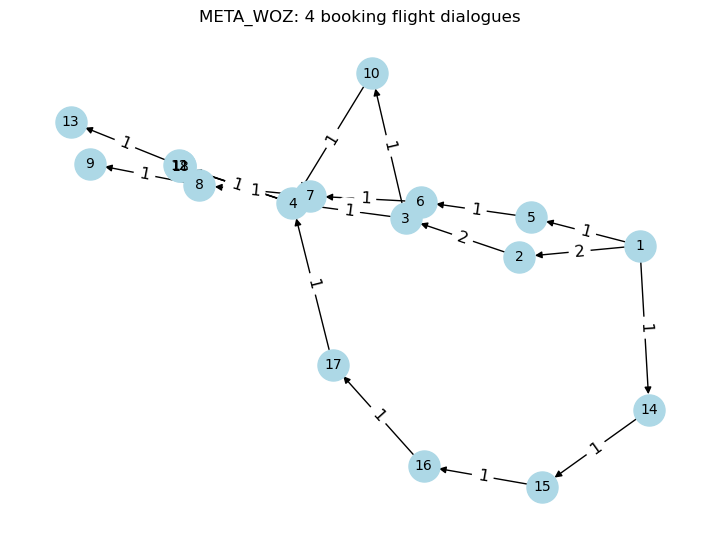

In [98]:
graph.visualise_short("META_WOZ: 4 booking flight dialogues")

In [101]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello how may I help you?']},
 {'id': 2,
  'label': 'provide_confirmation',
  'is_start': False,
  'utterances': ['Sure', 'sure what do you wanna know?']},
 {'id': 3,
  'label': 'offer_flight_booking',
  'is_start': False,
  'utterances': ['I can book a flight for you',
   'i can book you a flight there to save you some time']},
 {'id': 4,
  'label': 'ask_anything_else',
  'is_start': False,
  'utterances': ['Anything else?',
   'ohh okay anything else you need to know?',
   'I have booked that airline for you, anything else/']},
 {'id': 5,
  'label': 'ask_book_flight_to_greece',
  'is_start': False,
  'utterances': ['Can I help you book a flight to greece?']},
 {'id': 6,
  'label': 'ask_departure_time',
  'is_start': False,
  'utterances': ['Perfect, and when would you like to leave?']},
 {'id': 7,
  'label': 'confirm_departure',
  'is_start': False,
  'utterances': ['Alright, i have your flight leaving from dallas a

In [102]:
graph.graph_dict['edges']

[{'source': 1, 'target': 5, 'utterances': ['Hello, I want to book a flight.']},
 {'source': 5, 'target': 6, 'utterances': ["Yes that's where I want to go."]},
 {'source': 6, 'target': 7, 'utterances': ['I want to leave from Dallas.']},
 {'source': 7, 'target': 8, 'utterances': ['I want to leave by next Friday.']},
 {'source': 8,
  'target': 9,
  'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]},
 {'source': 3,
  'target': 10,
  'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]},
 {'source': 4, 'target': 11, 'utterances': ['Nope, thanks for your help!']},
 {'source': 10, 'target': 4, 'utterances': ['Okay, that seems pretty easy']},
 {'source': 1,
  'target': 2,
  'utterances': ['I need some help with some information please',
   'I need some travel information please.']},
 {'source': 2,
  'target': 3,
  'utterances': ['how do I get a flight to Greece?',
   'I need to know how I would g

In [129]:
test_data = [Dialogue.from_list(c) for c in new_data[:5]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello how may I help you?']}, {'id': 2, 'label': 'offer_booking', 'is_start': False, 'utterances': ['Can I help you book a flight to greece?', 'I can book a flight for you', 'i can book you a flight there to save you some time']}, {'id': 3, 'label': 'generic_confirmation', 'is_start': False, 'utterances': ['Sure', 'sure what do you wanna know?', 'Sure thing. And what can I help you with today?']}, {'id': 4, 'label': 'provide_booking_info', 'is_start': False, 'utterances': ['You can check airports has a schedule flight to Greece and there you can book a flight if you want to', "You will need to first make some research for the airport you are going to take. Then, you'll want to find out prices and seating arrangements. Finally, pick your destination and pay for the ticket, then wait at the terminal."]}, {'id': 5, 'label': 'ask_flight_details', 'is_start': False, 'utterances': ['Perfect, and when would you l

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='2', metadata={'id': 2}, page_content='Perfect, and when would you like to leave?'), 0.15744547028550726), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096082630853235), (Document(id='1', metadata={'id': 1}, page_content='Can I help you book a flight to greece?'), 0.08380725521054644), (Document(id='5', metadata={'id': 5}, page_content='Flight booking has been cancelled. We hope to see you again soon.'), 0.06941022893401316), (Document(id='3', metadata={'id': 3}, page_content='Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?'), 0.022034305222069506), (Document(id='4', metadata={'id': 4}, page_content='Alright booking your flight between now and next friday. You will be alerted when your flight 

RESULT:  {'edges': [{'source': 1, 'target': 2, 'utterances': ['Hello, I want to book a flight.']}, {'source': 2, 'target': 5, 'utterances': ["Yes that's where I want to go."]}, {'source': 5, 'target': 7, 'utterances': ['I want to leave from Dallas.']}, {'source': 8, 'target': 8, 'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]}, {'source': 2, 'target': 4, 'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]}, {'source': 4, 'target': 9, 'utterances': ['Okay, that seems pretty easy']}, {'source': 9, 'target': 10, 'utterances': ['Nope, thanks for your help!']}, {'source': 2, 'target': 9, 'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do."]}, {'source': 3, 'target': 2, 'utterances': ['how do I get a flight to Greece?', 'I need to know how I would go about getting a flight to Greece when I need to go.']}, {'source': 7, 'ta

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096074201483533), (Document(id='5', metadata={'id': 5}, page_content='I wish you luck on your flight to Greece~!'), 0.1361782548206072), (Document(id='1', metadata={'id': 1}, page_content='Sure thing. And what can I help you with today?'), 0.10788086073039294), (Document(id='4', metadata={'id': 4}, page_content='Is there anything else that I can help you with today?'), 0.10628863708734837), (Document(id='3', metadata={'id': 3}, page_content='You will also be boarding the plane, then fly across the world to reach your destination. You will then get off the plane and will have to find a travel service that can accommodate you to reach your destination.'), 0.03150714659968101), (Document(id='2', metadata={'id': 2}, page_

False

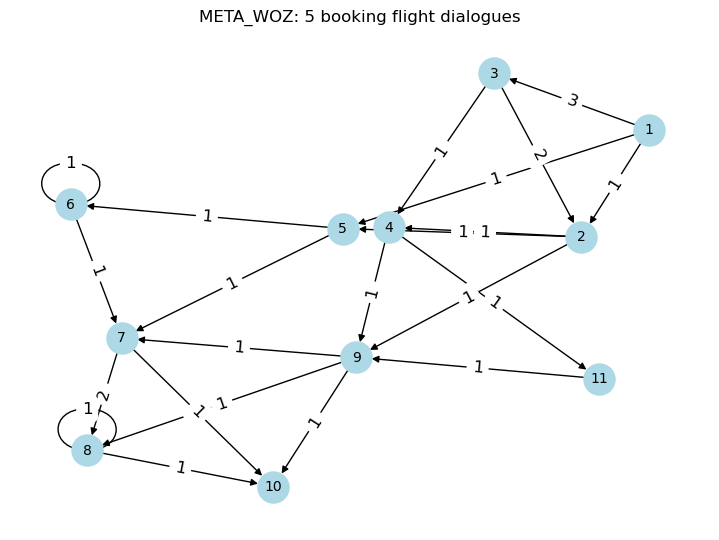

In [130]:
graph.visualise_short("META_WOZ: 5 booking flight dialogues")

In [132]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello how may I help you?']},
 {'id': 2,
  'label': 'offer_booking',
  'is_start': False,
  'utterances': ['Can I help you book a flight to greece?',
   'I can book a flight for you',
   'i can book you a flight there to save you some time']},
 {'id': 3,
  'label': 'generic_confirmation',
  'is_start': False,
  'utterances': ['Sure',
   'sure what do you wanna know?',
   'Sure thing. And what can I help you with today?']},
 {'id': 4,
  'label': 'provide_booking_info',
  'is_start': False,
  'utterances': ['You can check airports has a schedule flight to Greece and there you can book a flight if you want to',
   "You will need to first make some research for the airport you are going to take. Then, you'll want to find out prices and seating arrangements. Finally, pick your destination and pay for the ticket, then wait at the terminal."]},
 {'id': 5,
  'label': 'ask_flight_details',
  'is_start': False,
  'utterances': 

In [131]:
graph.graph_dict['edges']

[{'source': 1, 'target': 2, 'utterances': ['Hello, I want to book a flight.']},
 {'source': 2, 'target': 5, 'utterances': ["Yes that's where I want to go."]},
 {'source': 5, 'target': 7, 'utterances': ['I want to leave from Dallas.']},
 {'source': 8,
  'target': 8,
  'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]},
 {'source': 2,
  'target': 4,
  'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]},
 {'source': 4, 'target': 9, 'utterances': ['Okay, that seems pretty easy']},
 {'source': 9, 'target': 10, 'utterances': ['Nope, thanks for your help!']},
 {'source': 2,
  'target': 9,
  'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do."]},
 {'source': 3,
  'target': 2,
  'utterances': ['how do I get a flight to Greece?',
   'I need to know how I would go about getting a flight to Greece when I need to go.']},
 {'source

In [ ]:
test_data = [Dialogue.from_list(c) for c in new_data[:6]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

In [ ]:
graph.visualise_short("META_WOZ: 4 similar booking flight dialogues")

In [122]:
test_data = [Dialogue.from_list(c) for c in new_data[1:3]+new_data[6:9:2]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello how may I help you?']}, {'id': 2, 'label': 'affirmative_response', 'is_start': False, 'utterances': ['Sure', 'sure what do you wanna know?', 'Sure, how can I help']}, {'id': 3, 'label': 'offer_booking', 'is_start': False, 'utterances': ['I can book a flight for you', 'i can book you a flight there to save you some time', 'You rather want me to book a flight for you to Greece?', 'Do you want me to book you a flight or do you want info on how to book a flight']}, {'id': 4, 'label': 'provide_flight_options', 'is_start': False, 'utterances': ['You can check airports has a schedule flight to Greece and there you can book a flight if you want to', 'Check airports to have flight to Greece and you can check schedule of the flight and price.', 'Okay there is the airport as one option. Secondly, there are websites like travelocity, expedia, or the airlines own website']}, {'id': 5, 'label': 'ask_anything_else'

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='2', metadata={'id': 2}, page_content='I can book a flight for you'), 0.723295571401247), (Document(id='3', metadata={'id': 3}, page_content='You can check airports has a schedule flight to Greece and there you can book a flight if you want to'), 0.5478733915220533), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.411750324040418), (Document(id='4', metadata={'id': 4}, page_content='Anything else?'), 0.24858364691807044), (Document(id='1', metadata={'id': 1}, page_content='Sure'), 0.07874154119432508), (Document(id='5', metadata={'id': 5}, page_content='Great'), -0.0013846754467057298)]
  docs = self.assistant_store.similarity_search_with_relevance_scores(utterance, k=self.assistant_size, score_threshold=env_settings.EMBEDDER_TYPO)
/data/home/peshkichev/

RESULT:  {'edges': [{'source': 3, 'target': 5, 'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do."]}, {'source': 5, 'target': 6, 'utterances': ['Just for my own information, can you tell me how much a flight to Greece costs right now?']}, {'source': 6, 'target': 7, 'utterances': ['That is a great price. Thanks for the information.']}, {'source': 1, 'target': 3, 'utterances': ['need info about booking a flight to a place such as Greece']}, {'source': 4, 'target': 5, 'utterances': ['Okay, that seems pretty easy', 'alright thanks for this info']}, {'source': 5, 'target': 7, 'utterances': ['Nope, thanks for your help!', 'no that is all i need for my research at the moment']}, {'source': 7, 'target': 7, 'utterances': ['bye']}, {'source': 1, 'target': 2, 'utterances': ['I need some help with some information please', 'I need some travel information please.', 'Can you help me get information about a flights?']}, {'source':

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='1', metadata={'id': 1}, page_content='Sure, how can I help'), 0.22115220197736107), (Document(id='5', metadata={'id': 5}, page_content='No problem, anything else'), 0.1941040404770097), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096091060222937), (Document(id='4', metadata={'id': 4}, page_content='It could close to 1000 cost'), 0.08375415018142274), (Document(id='2', metadata={'id': 2}, page_content='Do you want me to book you a flight or do you want info on how to book a flight'), -0.001384506859311685), (Document(id='3', metadata={'id': 3}, page_content='Okay there is the airport as one option. Secondly, there are websites like travelocity, expedia, or the airlines own website'), -0.022209349002241474)]
  docs = self.assistant_store.similarity_

False

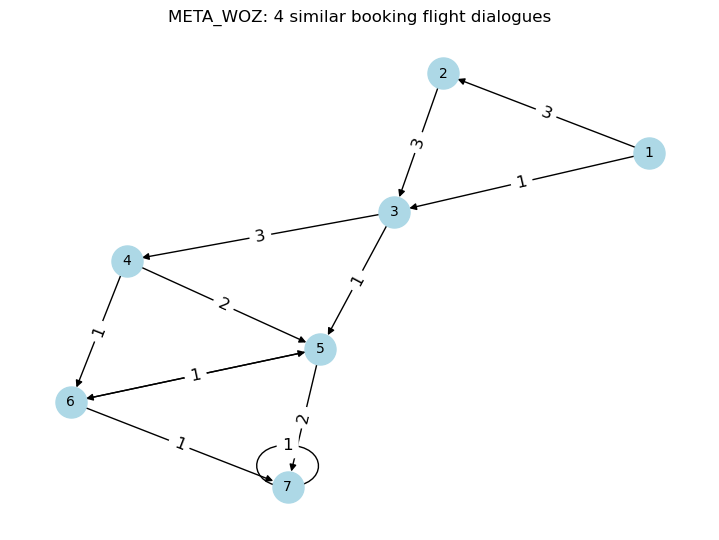

In [123]:
graph.visualise_short("META_WOZ: 4 similar booking flight dialogues")

In [125]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello how may I help you?']},
 {'id': 2,
  'label': 'affirmative_response',
  'is_start': False,
  'utterances': ['Sure',
   'sure what do you wanna know?',
   'Sure, how can I help']},
 {'id': 3,
  'label': 'offer_booking',
  'is_start': False,
  'utterances': ['I can book a flight for you',
   'i can book you a flight there to save you some time',
   'You rather want me to book a flight for you to Greece?',
   'Do you want me to book you a flight or do you want info on how to book a flight']},
 {'id': 4,
  'label': 'provide_flight_options',
  'is_start': False,
  'utterances': ['You can check airports has a schedule flight to Greece and there you can book a flight if you want to',
   'Check airports to have flight to Greece and you can check schedule of the flight and price.',
   'Okay there is the airport as one option. Secondly, there are websites like travelocity, expedia, or the airlines own website']},
 {'id': 

In [124]:
graph.graph_dict['edges']

[{'source': 3,
  'target': 5,
  'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do."]},
 {'source': 5,
  'target': 6,
  'utterances': ['Just for my own information, can you tell me how much a flight to Greece costs right now?']},
 {'source': 6,
  'target': 7,
  'utterances': ['That is a great price. Thanks for the information.']},
 {'source': 1,
  'target': 3,
  'utterances': ['need info about booking a flight to a place such as Greece']},
 {'source': 4,
  'target': 5,
  'utterances': ['Okay, that seems pretty easy',
   'alright thanks for this info']},
 {'source': 5,
  'target': 7,
  'utterances': ['Nope, thanks for your help!',
   'no that is all i need for my research at the moment']},
 {'source': 7, 'target': 7, 'utterances': ['bye']},
 {'source': 1,
  'target': 2,
  'utterances': ['I need some help with some information please',
   'I need some travel information please.',
   'Can you help me get information abo

In [138]:
test_data = [Dialogue.from_list(c) for c in new_data[1:3]+new_data[6:9:2]+[new_data[11]]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello how may I help you?']}, {'id': 2, 'label': 'ask_specifics', 'is_start': False, 'utterances': ['Sure', 'sure what do you wanna know?', 'You rather want me to book a flight for you to Greece?', 'Sure, how can I help', 'what can I do for you']}, {'id': 3, 'label': 'offer_booking_or_info', 'is_start': False, 'utterances': ['I can book a flight for you', 'i can book you a flight there to save you some time', 'Check airports to have flight to Greece and you can check schedule of the flight and price.', 'Do you want me to book you a flight or do you want info on how to book a flight', 'I can do that for you. When do you want to leave?']}, {'id': 4, 'label': 'ask_anything_else', 'is_start': False, 'utterances': ['Anything else?', 'ohh okay anything else you need to know?', 'No problem, anything else', 'okay, is there anything else I can do for you?']}, {'id': 5, 'label': 'providing_information', 'is_start': 

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='3', metadata={'id': 3}, page_content='You can check airports has a schedule flight to Greece and there you can book a flight if you want to'), 0.8507242287238428), (Document(id='2', metadata={'id': 2}, page_content='I can book a flight for you'), 0.44574310606360634), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.1664673403840522), (Document(id='1', metadata={'id': 1}, page_content='Sure'), 0.11148846237553145), (Document(id='4', metadata={'id': 4}, page_content='Anything else?'), 0.0835043879571471), (Document(id='5', metadata={'id': 5}, page_content='Great'), -0.008978273142913551)]
  docs = self.assistant_store.similarity_search_with_relevance_scores(utterance, k=self.assistant_size, score_threshold=env_settings.EMBEDDER_TYPO)
/data/home/peshkichev

RESULT:  {'edges': [{'source': 4, 'target': 8, 'utterances': ['Nope, thanks for your help!']}, {'source': 4, 'target': 6, 'utterances': ['Just for my own information, can you tell me how much a flight to Greece costs right now?']}, {'source': 6, 'target': 7, 'utterances': ['That is a great price. Thanks for the information.']}, {'source': 3, 'target': 4, 'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do.", 'alright thanks for this info']}, {'source': 7, 'target': 7, 'utterances': ['bye']}, {'source': 5, 'target': 6, 'utterances': ['How much do flights to Greece usually cost?']}, {'source': 6, 'target': 4, 'utterances': ['Okay. Thanks for your helpful information!']}, {'source': 1, 'target': 2, 'utterances': ['I need some help with some information please', 'I need some travel information please.', 'need info about booking a flight to a place such as Greece', 'Can you help me get information about a flights?', 'i hav

False

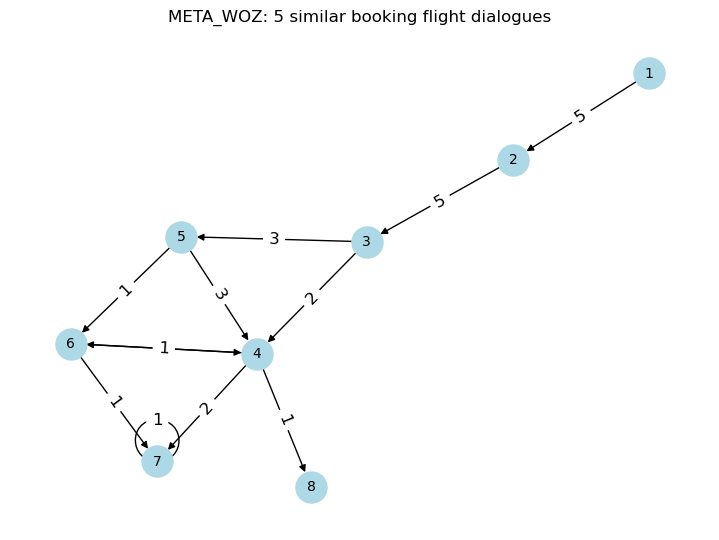

In [139]:
graph.visualise_short("META_WOZ: 5 similar booking flight dialogues")

In [140]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello how may I help you?']},
 {'id': 2,
  'label': 'ask_specifics',
  'is_start': False,
  'utterances': ['Sure',
   'sure what do you wanna know?',
   'You rather want me to book a flight for you to Greece?',
   'Sure, how can I help',
   'what can I do for you']},
 {'id': 3,
  'label': 'offer_booking_or_info',
  'is_start': False,
  'utterances': ['I can book a flight for you',
   'i can book you a flight there to save you some time',
   'Check airports to have flight to Greece and you can check schedule of the flight and price.',
   'Do you want me to book you a flight or do you want info on how to book a flight',
   'I can do that for you. When do you want to leave?']},
 {'id': 4,
  'label': 'ask_anything_else',
  'is_start': False,
  'utterances': ['Anything else?',
   'ohh okay anything else you need to know?',
   'No problem, anything else',
   'okay, is there anything else I can do for you?']},
 {'id': 5,
  '

In [141]:
graph.graph_dict['edges']

[{'source': 4, 'target': 8, 'utterances': ['Nope, thanks for your help!']},
 {'source': 4,
  'target': 6,
  'utterances': ['Just for my own information, can you tell me how much a flight to Greece costs right now?']},
 {'source': 6,
  'target': 7,
  'utterances': ['That is a great price. Thanks for the information.']},
 {'source': 3,
  'target': 4,
  'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do.",
   'alright thanks for this info']},
 {'source': 7, 'target': 7, 'utterances': ['bye']},
 {'source': 5,
  'target': 6,
  'utterances': ['How much do flights to Greece usually cost?']},
 {'source': 6,
  'target': 4,
  'utterances': ['Okay. Thanks for your helpful information!']},
 {'source': 1,
  'target': 2,
  'utterances': ['I need some help with some information please',
   'I need some travel information please.',
   'need info about booking a flight to a place such as Greece',
   'Can you help me get information a

In [143]:
dataset = load_dataset("GEM/schema_guided_dialog", trust_remote_code=True)

Generating train split:   0%|          | 0/164982 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating challenge_train_sample split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_validation_sample split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_test_backtranslation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_test_bfp02 split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_test_bfp05 split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_test_nopunc split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_test_scramble split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [144]:
dataset

DatasetDict({
    train: Dataset({
        features: ['gem_id', 'gem_parent_id', 'dialog_acts', 'context', 'dialog_id', 'service', 'turn_id', 'prompt', 'target', 'references', 'linearized_input'],
        num_rows: 164982
    })
    validation: Dataset({
        features: ['gem_id', 'gem_parent_id', 'dialog_acts', 'context', 'dialog_id', 'service', 'turn_id', 'prompt', 'target', 'references', 'linearized_input'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['gem_id', 'gem_parent_id', 'dialog_acts', 'context', 'dialog_id', 'service', 'turn_id', 'prompt', 'target', 'references', 'linearized_input'],
        num_rows: 10000
    })
    challenge_train_sample: Dataset({
        features: ['gem_id', 'gem_parent_id', 'dialog_acts', 'context', 'dialog_id', 'service', 'turn_id', 'prompt', 'target', 'references', 'linearized_input'],
        num_rows: 500
    })
    challenge_validation_sample: Dataset({
        features: ['gem_id', 'gem_parent_id', 'dialog_acts', 'conte

In [146]:
dataset['test'][0]

{'gem_id': 'schema_guided_dialog-test-0',
 'gem_parent_id': 'schema_guided_dialog-test-0',
 'dialog_acts': [{'act': 4, 'slot': 'price_per_day', 'values': ['$36.00']},
  {'act': 10, 'slot': '', 'values': []}],
 'context': ["I'm having a friend visit and we want some fun attractions to go to, maybe a museum. Can you find one for me?",
  'In which city should I search in?',
  'Please look for attractions in London, UK.',
  'I suggest a museum called Apsley House.',
  'Is there anything else? Preferably something child-friendly.',
  'I suggest a museum called BODY WORLDS London.',
  'Where can I contact them?',
  'You can contact them at 330 223 3233.',
  'Is there a cost to enter the museum?',
  'No, it is free to enter.',
  "That's great. Can you also find me a rental car? I'd like to pick it up by morning 11 and I need it next Thursday.",
  'When do you want to return the car?',
  'I will be needing the car until the 10th of March.',
  'Are you planning to pick it up from London?',
  'Y

In [147]:
dataset['test'][1]

{'gem_id': 'schema_guided_dialog-test-1',
 'gem_parent_id': 'schema_guided_dialog-test-1',
 'dialog_acts': [{'act': 2,
   'slot': 'pickup_location',
   'values': ['LGB Airport']},
  {'act': 2, 'slot': 'start_date', 'values': ['March 9th']},
  {'act': 2, 'slot': 'pickup_time', 'values': ['5 pm']},
  {'act': 2, 'slot': 'end_date', 'values': ['March 14th']},
  {'act': 2, 'slot': 'car_type', 'values': ['Hatchback']},
  {'act': 2, 'slot': 'add_insurance', 'values': ['False']}],
 'context': ['I need to purchase tickets.',
  'Where are you travelling? What date and time would you like to leave?Ho',
  'I am going to LOng Beach on the 7th of March in the afternoon 3:15.',
  'Where are you departing from?',
  'I am departing from SD.',
  'How many tickets will you need?',
  'FOr 2 please.',
  'You want 2 tickets to from Long Beach to San Diego on March 7th at 3:15 pm, correct?',
  'Yes that is correct, is it a direct bus?',
  'It is a direct trip, but that time is unavailable. How about 3:20 pm,